In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

In [3]:
jax.devices()

[cuda(id=0)]

In [4]:
key = jax.random.PRNGKey(0)

In [5]:
task = get_task("lotka_volterra")
prior = task.get_prior()
simulator = task.get_simulator()

In [6]:
key = jax.random.PRNGKey(0)
theta_o = prior.sample(key)
num_obs = 101
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[ 1.816 -0.755  0.34  -0.535]


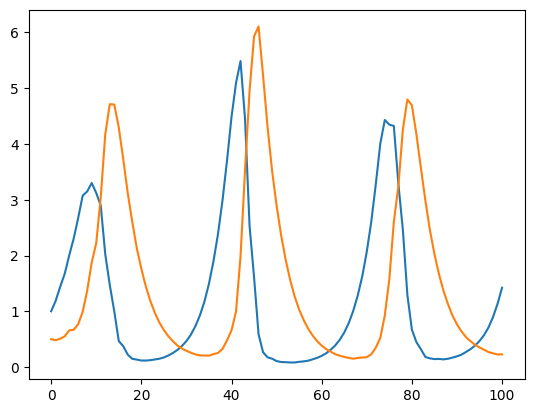

In [7]:
plt.plot(x_o)

In [154]:

# This will focus on the specific observations!
def targeted_proposal(key):
    key, subkey = jax.random.split(key)
    idx = jax.random.randint(key, (1,), 0, num_obs)
    x = x_o[idx][0]
    eps = jax.random.normal(subkey, (2,))*0.01
    return x + eps


In [155]:
x0s = jax.vmap(targeted_proposal)(jax.random.split(key+1, 10_000))

data = task.get_data(key, 10_000, 2, x0=x0s)

In [156]:
sde, weight_fn = init_sde(data)

In [157]:
key, key_init = jax.random.split(key)

In [158]:
c_in, c_noise, c_out = precondition_functions(sde)
init_fn, score_net = build_score_mlp(2, num_hidden=5, c_in=c_in, c_noise=c_noise, c_out=c_out)
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn,control_variate=True)

In [159]:
theta_batch, x_batch = batch_sampler(key_init, 50)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

(50, 4) (50, 2, 2)


In [160]:
params = init_fn(key_init, jnp.ones((50,)), theta_batch, x_batch)

In [161]:
loss_fn(params, key,theta_batch, x_batch)

Array(27.114, dtype=float32)

In [162]:

schedule = optax.cosine_onecycle_schedule (
    200_000, 5e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(10), optax.ema(0.01), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [163]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [164]:
for i in range(20):
    l = 0.
    for _ in range(10000):
        key, key_batch = jax.random.split(key)
        theta_batch, x_batch = batch_sampler(key_batch, 1024)
        loss, params, opt_state = update(params, key, opt_state, theta_batch, x_batch)
        l += loss/10000
    print(l)

26.097504
24.914322
24.678661
24.526829
24.545887
24.497816
24.48947
24.451582
24.400967
24.328606
24.377094
24.243303
24.303955
24.234898
24.177382
24.207594
24.143257
24.065273
24.066784
23.996752


In [165]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [166]:
score_fn = FNPEScoreFn(score_net, params, sde, prior)
score_fn = UncorrectedScoreFn(score_net, params, sde,prior)
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
#score_fn = CorrectedScoreFn(score_net, params, sde, prior, precission_nugget=0.1)

In [167]:
key = jax.random.PRNGKey(0)
theta_o = prior.sample(key)
num_obs = 21
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[ 1.816 -0.755  0.34  -0.535]


In [195]:
score_fn.estimate_hyperparameters(x_o, theta_o.shape, key+1231, precission_nugget=0.0001, num_samples=2000)

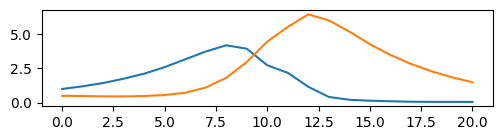

In [196]:
fig = plt.figure(figsize=(5,1.5))
plt.plot(x_o)
plt.tight_layout()
plt.savefig("obs.png")

In [197]:

from markovsbi.sampling.sample import Diffuser, clip_transform
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM

kernel = EulerMaruyama(score_fn)
length = 1000
time_grid = jnp.linspace(sde.T_min, sde.T_max, length)
sampler = Diffuser(kernel, time_grid, (d,))


In [198]:
traces = jax.vmap(sampler.simulate, in_axes=(0,None))(jax.random.split(key,(100,)), x_o)

(-5.0, 5.0)

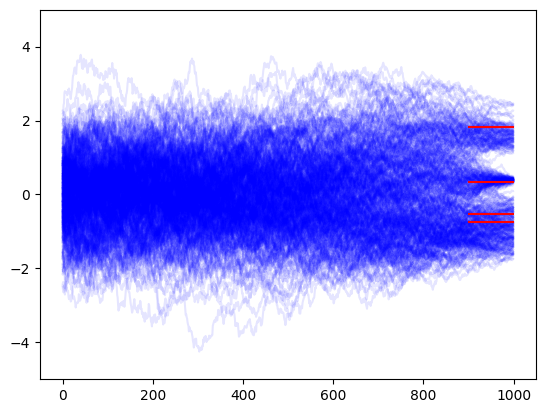

In [199]:
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, length-length/10, length, color="red")
plt.ylim(-5,5)

In [200]:
samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 3000), x_o)

In [192]:

true_posterior = task.get_true_posterior(x_o,n_particles=500, obs_ll=1e-3, thin=10)
true_samples = true_posterior.sample(jax.random.PRNGKey(1), (3000,))

/tmp/ipykernel_13404/1622231967.py:4: UserWarning: offdiag is deprecated, use upper or lower instead.
  pairplot([np.array(samples), np.array(true_samples)], points = np.array(theta_o), limits = [(-2,2)]*10, offdiag="scatter")


(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>,
         <Axes: xlabel='dim 3'>, <Axes: xlabel='dim 4'>]], dtype=object))

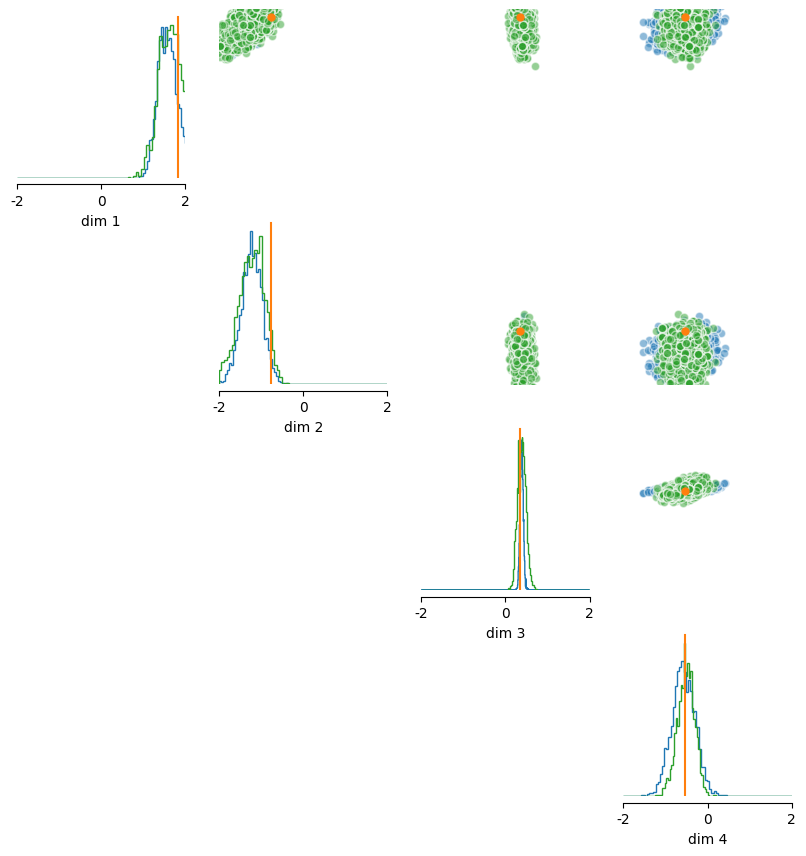

In [201]:
from sbi.analysis import pairplot
import numpy as np

pairplot([np.array(samples), np.array(true_samples)], points = np.array(theta_o), limits = [(-2,2)]*10, offdiag="scatter")

In [194]:
from sbi.utils.metrics import c2st
import torch

c2st(torch.tensor(np.array(samples)), torch.tensor(np.array(true_samples)))

tensor(0.8807, dtype=torch.float64)